In [ ]:
from asap.data.dataloader import DataSet
from asap.util import topics
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


sample_in = '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/simdata/simdata_a_1.0_r_0.9_d_10000_s_1000'
sample_out = '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/simdata/a_1.0_r_0.9_d_10000_s_1000/'

dl = DataSet(sample_in,sample_out,data_mode='sparse',data_ondisk=False)
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


In [ ]:
model = np.load(sample_out+'_altnmf.npz')

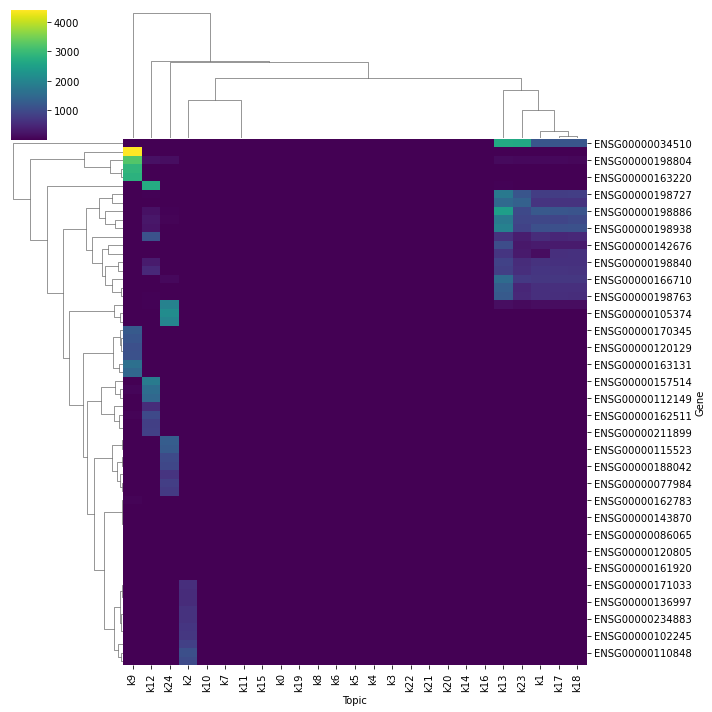

In [4]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = dl.cols
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
sns.clustermap(df_top.T,cmap='viridis')

In [5]:
import umap
df_theta = pd.DataFrame(model['corr'])
df_umap= pd.DataFrame()
df_umap['cell'] = dl.rows
df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.9,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

,cell,topic_bulk,umap1,umap2
0,"0_Tcell,CD4,naive[activated]",2,6.267914,11.214918
1,"1_Tcell,CD4,naive[activated]",2,4.794067,10.701788
2,"2_Tcell,CD4,naive[activated]",2,4.802295,8.776899
3,"3_Tcell,CD4,naive[activated]",2,5.568174,11.682683
4,"4_Tcell,CD4,naive[activated]",2,7.784457,10.953838
...,...,...,...,...
14995,"995_Tcell,CD8,naive[activated]",1,11.878393,0.705462
14996,"996_Tcell,CD8,naive[activated]",1,11.999780,0.750058
14997,"997_Tcell,CD8,naive[activated]",1,12.793212,-1.225272
14998,"998_Tcell,CD8,naive[activated]",1,13.475774,-0.018680


Text(0, 0.5, 'UMAP2')

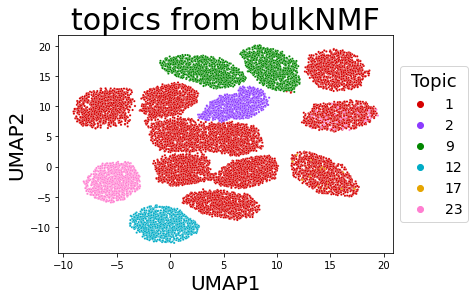

In [6]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

Text(0, 0.5, 'UMAP2')

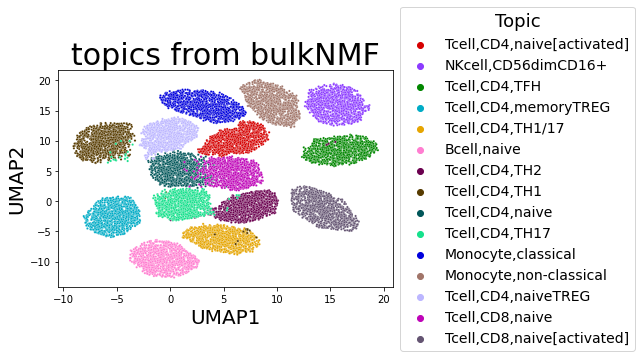

In [7]:
df_umap['cell_type'] = [x.split('_')[1] for x in df_umap['cell']]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

In [9]:
bulk_data = '/home/BCCRC.CA/ssubedi/projects/experiments/asapp/resources/dice/mean_tpm_merged.csv.gz'
df_dice = pd.read_csv(bulk_data,compression='zip')

df_dice = df_dice.set_index('gene').T

Text(218.45454545454544, 0.5, 'bulk')

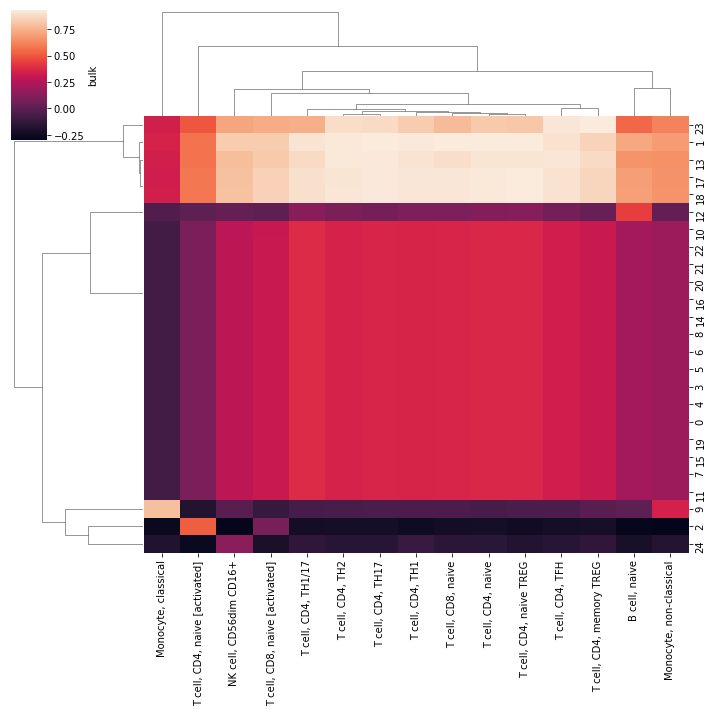

In [10]:
sel_top_genes = list(np.unique(topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=10)['Gene'].values))
K=10
corr=[]
for i in df_beta.index:
    cr = []
    for j in df_dice.index:
        cr.append(np.corrcoef(df_beta.loc[i,sel_top_genes],df_dice.loc[j,sel_top_genes])[0,1])
    corr.append(cr)

df_corr = pd.DataFrame(corr)
df_corr.index = df_beta.index
df_corr.columns = df_dice.index
sns.clustermap(df_corr)
plt.xlabel('sc')
plt.ylabel('bulk')

In [11]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match


cell                                      
topic_bulk                      1       2       9       12    17      23
cell_type                                                               
Bcell,naive                    0.0     0.0     0.0  1000.0   0.0     0.0
Monocyte,classical             0.0     0.0  1000.0     0.0   0.0     0.0
Monocyte,non-classical         3.0     0.0   997.0     0.0   0.0     0.0
NKcell,CD56dimCD16+         1000.0     0.0     0.0     0.0   0.0     0.0
Tcell,CD4,TFH                903.0     0.0     0.0     0.0   0.0    97.0
Tcell,CD4,TH1               1000.0     0.0     0.0     0.0   0.0     0.0
Tcell,CD4,TH1/17            1000.0     0.0     0.0     0.0   0.0     0.0
Tcell,CD4,TH17              1000.0     0.0     0.0     0.0   0.0     0.0
Tcell,CD4,TH2               1000.0     0.0     0.0     0.0   0.0     0.0
Tcell,CD4,memoryTREG           0.0     0.0     0.0     0.0   0.0  1000.0
Tcell,CD4,naive             1000.0     0.0     0.0     0.0   0.0     0.0
Tcell,CD4,naiveTREG         1000.0     0.0     0.0     0.0   0.0     0.0
Tcell,CD4,naive[activated]     0.0  1000.0     0.0     0.0   0.0     0.0
Tcell,CD8,naive             1000.0     0.0     0.0     0.0   0.0     0.0
Tcell,CD8,naive[activated]   970.0     0.0     0.0     0.0  30.0     0.0

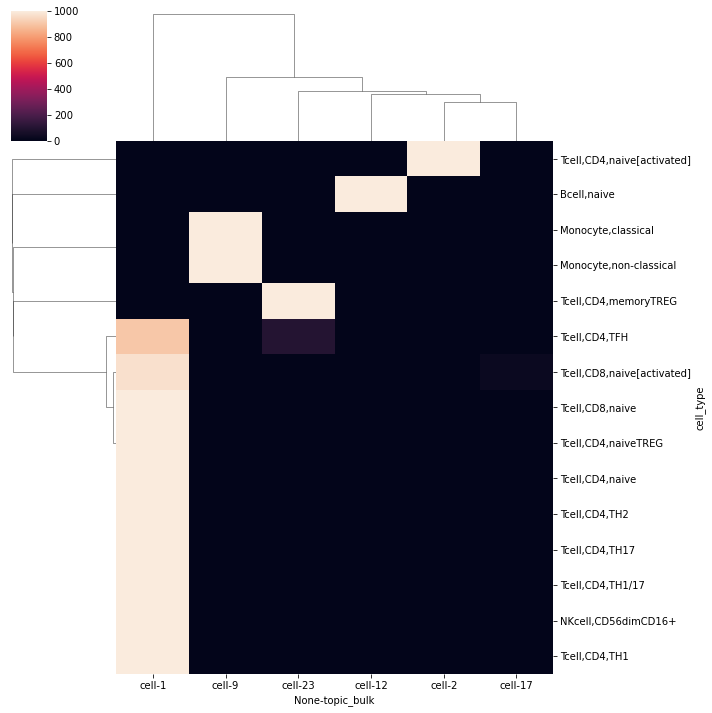

In [12]:
sns.clustermap(df_match)

In [13]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)

0.5643095569118368